In [11]:
import pandas as pd
import json
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm
from datasketch import MinHash, MinHashLSH

def preprocess_text(text, lemmatize=True, stem=False):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = [word for word in text.split() if word not in stop_words]

    if lemmatize:
        words = [lemmatizer.lemmatize(word) for word in words]
    if stem:
        words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

In [12]:
def text_to_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    words = text.split()
    for word in words:
        m.update(word.encode('utf8'))
    return m

def lsh_similarity(ids, texts, num_perm=128, threshold=0.4):
    preprocessed_texts = [preprocess_text(text) for text in tqdm(texts, desc="Preprocessing texts")]
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)

    minhashes = []
    for text in tqdm(preprocessed_texts, desc="Creating MinHashes"):
        minhashes.append(text_to_minhash(text, num_perm=num_perm))

    for idx, m in enumerate(minhashes):
        lsh.insert(ids[idx], m)

    predictions = {}
    for idx, id_ in enumerate(tqdm(ids, desc='Finding similar items')):
        minhash = text_to_minhash(preprocessed_texts[idx], num_perm=num_perm)
        similar_items = lsh.query(minhash)
        similar_items = [item for item in similar_items if item != id_]
        predictions[id_] = similar_items[:5]

    return predictions

In [13]:
def evaluate_model(predictions, ground_truth_file):
    with open(ground_truth_file, 'r') as f:
        ground_truth = json.load(f)

    total_score = 0
    scores = []

    for id_, pred_items in predictions.items():
        gt_items = ground_truth.get(id_, [])
        intersection_score = len(set(pred_items).intersection(set(gt_items)))
        scores.append(intersection_score)
        total_score += intersection_score

    avg_score = total_score / len(predictions) if len(predictions) > 0 else 0
    return avg_score, scores

## Reading input files

In [14]:
with open('ids.txt', 'r', encoding='utf-8') as file:
    ids = [line.strip() for line in file]

with open('texts.txt', 'r', encoding='utf-8') as file:
    texts = [line.strip() for line in tqdm(file, desc="Reading texts")]

Reading texts: 0it [00:00, ?it/s]

Reading texts: 148928it [00:00, 274348.63it/s]


## Generating LSH predictions

In [15]:
predictions = lsh_similarity(ids, texts)

Finding similar items: 100%|██████████| 148928/148928 [10:17<00:00, 241.25it/s]


## Evaluating the predictions (by comparing with groundtruth, items.json)

In [16]:
avg, scores = evaluate_model(predictions, 'items.json')

### Average Score: 0.007 (approximately)

In [17]:
print(f"Average score: {avg:.5f}")

Average score: 0.00688


### Summary of the dataframe

In [18]:
scores_df = pd.Series(scores)
scores_df.describe()

count    148928.000000
mean          0.006883
std           0.083805
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
dtype: float64

## Plotting the scores

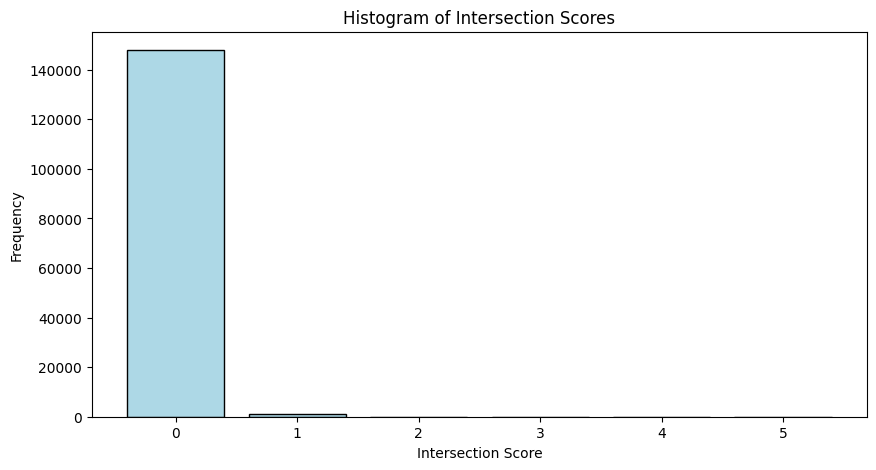

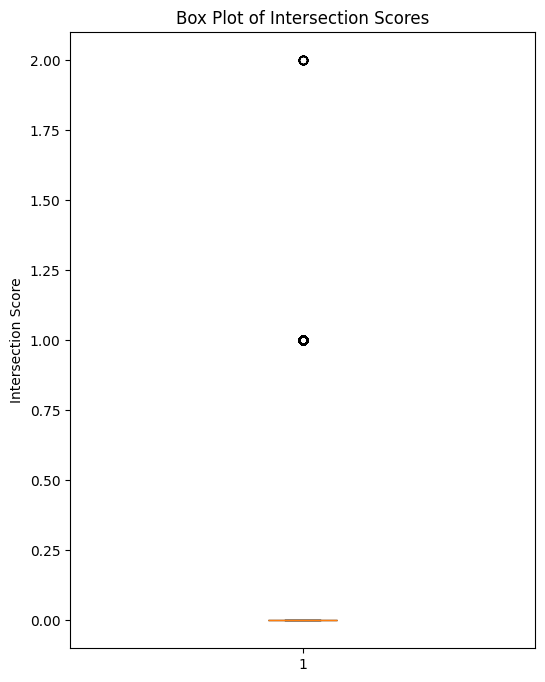

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(scores, bins=range(0, 7), color='lightblue', edgecolor='black', align='left', rwidth=0.8)
plt.xticks(range(0, 6))  
plt.xlabel("Intersection Score")
plt.ylabel("Frequency")
plt.title("Histogram of Intersection Scores")
plt.show()

plt.figure(figsize=(6, 8))
plt.boxplot(scores, vert=True, patch_artist=True)
plt.title("Box Plot of Intersection Scores")
plt.ylabel("Intersection Score")
plt.show()


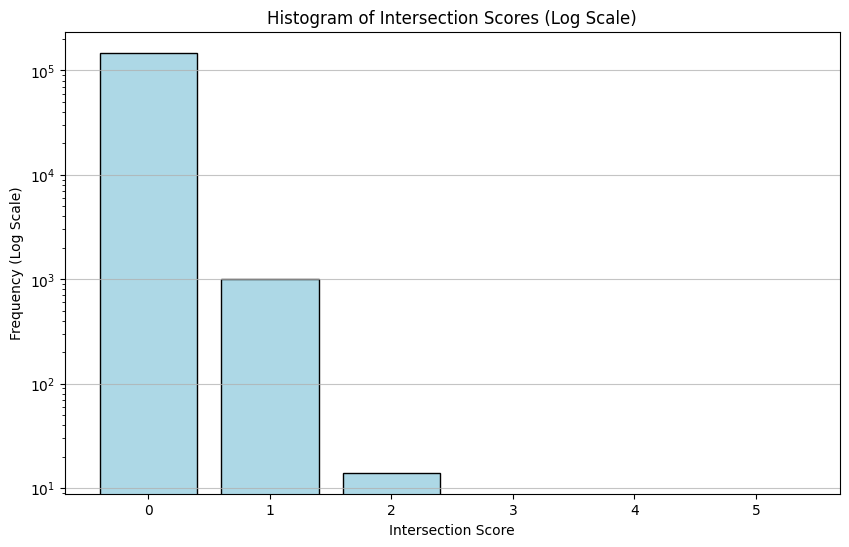

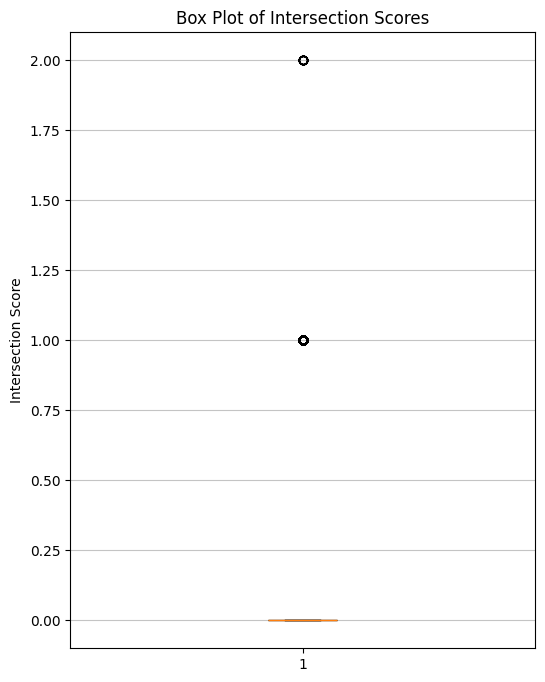

In [29]:

plt.figure(figsize=(10, 6))
plt.hist(scores_df, bins=range(7), align='left', rwidth=0.8, color='lightblue', edgecolor='black')
plt.yscale('log')  
plt.xlabel('Intersection Score')
plt.ylabel('Frequency (Log Scale)')
plt.title('Histogram of Intersection Scores (Log Scale)')
plt.xticks(range(6))
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(6, 8))
plt.boxplot(scores_df, vert=True, patch_artist=True,flierprops=dict(marker='o', color='red', markersize=6)) 
plt.ylabel('Intersection Score')
plt.title('Box Plot of Intersection Scores')
plt.grid(axis='y', alpha=0.75)
plt.show()



In [30]:
scores_df = pd.Series(scores)
scores_df.describe()

count    148928.000000
mean          0.006883
std           0.083805
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
dtype: float64